In [8]:
import numpy as np
import scipy.integrate as scp
import scipy.special as sc
import statistics as st
import matplotlib.pyplot as plt
import os
import multiprocessing as mp

# parameters for eps, del, the
e = 0.25
d = 0.5
t = 1

# generating balanced weight matrix
def weight_matrix_bal(matrix_size,p,q):
    mat = np.zeros((matrix_size, matrix_size))

    # sc_p = (p*10)/matrix_size
    # sc_q = (q*10)/matrix_size

    sc_p = p
    sc_q = q

    # print(sc_p)
    # print(sc_q)

    possible_vals = (-2,-1,1,2)
    weights = (1-sc_p,sc_p*((1-sc_q)/2),sc_p*((1-sc_q)/2),sc_p*sc_q)
    # print(weights)

    for i in range(matrix_size):
        for j in range(matrix_size):
            if i >= j:
                continue
            else:
                mat[i,j] = np.random.choice(possible_vals, 1, p=weights)[0]
    # print(mat)

    for i in range(matrix_size):
        for j in range(matrix_size):
            # if mat[i,j] == -2:
            #     mat[i,j] = -1-d
            #     mat[j,i] = -1-d
            if mat[i,j] == 2:
                mat[i,j] = -1+e
                mat[j,i] = -1+e
            if mat[i,j] == -2:
                mat[i,j] = -1-d
                mat[j,i] = -1-d
            if mat[i,j] == -1:
                mat[i,j] = -1-d
                mat[j,i] = -1+e
            if mat[i,j] == 1:
                mat[i,j] = -1+e
                mat[j,i] = -1-d

    # print(mat)
    return(mat)

def mat_graph(mat, matrix_size):
    mat_graph = mat.copy()

    for i in range(matrix_size):
        for j in range(matrix_size):
            if mat_graph[i,j] == -1-d:
                mat_graph[i,j] = 0
            if mat_graph[i,j] == -1+e:
                mat_graph[i,j] = 1
            # print(i,j)
    return(mat_graph)

def is_bidirectional_clique(mat, nodes):
    # If there's only one node, it's trivially a bidirectional clique (no edges needed)
    if len(nodes) == 1:
        return True
    
    # Otherwise, proceed with the regular check for multiple nodes
    submat = mat[np.ix_(nodes, nodes)].copy()
    np.fill_diagonal(submat, 0)  # Exclude diagonal, as self-loops aren't relevant

    # Check for bidirectional edges (mat[i, j] == mat[j, i] == -0.75)
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):  # Only check upper triangle (avoiding duplicates)
            if not (submat[i, j] == submat[j, i] == -0.75):
                return False
    return True

def is_maximal_clique(mat, nodes):
    # Check if the clique is maximal: no outside node can be added while preserving the clique property.
    V = np.arange(mat.shape[0])
    outside = np.setdiff1d(V, nodes)
    for w in outside:
        extended = np.append(nodes, w)
        if is_bidirectional_clique(mat, extended):
            return False
    return True

def is_target_free(mat, nodes):
    V = np.arange(mat.shape[0])
    outside = np.setdiff1d(V, nodes)
    for x in outside:
        # Check if every i in the clique has a forward edge to x
        if np.all(np.isin(mat[nodes, x], [1, 2])):
            return False
    return True

def validate_fixed_point_structure(mat, final_state, threshold=0.1):
    active = np.where(final_state > threshold)[0]
    if len(active) == 0:
        return False, active  # no active nodes at all
    if len(active) == 1:
        return True, active   # singleton: trivially valid
    if not is_bidirectional_clique(mat, active):
        return False, active
    if not is_maximal_clique(mat, active):
        return False, active
    if not is_target_free(mat, active):
        return False, active
    return True, active




In [ ]:
# matrix size
mat_size = 50
param_average = np.zeros((11,11))
p_chart = np.zeros((11,11))
q_chart = np.zeros((11,11))

fig, axs = plt.subplots(11, 11, figsize=(40,40), sharex=True, sharey=True)

for counter_x in range(11):
    p = round(counter_x * 0.1, 2)
    for counter_y in range(11):
        q = round(counter_y * 0.1, 2)
        trial_close = []

        for k in range(10):  # range(n) n trials
            W = weight_matrix_bal(mat_size, p, q)
            A = np.copy(W)  # A is defined locally for stability
            
            # define the dynamical system
            def sys(t, x):
                x = x.reshape(-1, 1)  # x col vector
                dxdt = -x + np.maximum(0, A @ x + 1)
                return dxdt.flatten()  # flatten for solve_ivp
            
            # solver
            x0 = np.random.rand(mat_size, 1)
            time = [0, 600]
            sol = scp.solve_ivp(sys, time, x0.flatten(), method='BDF', dense_output=False)

            # fixed-point detection
            final_state = sol.y[:, -1]
            dxdt_final = sys(sol.t[-1], final_state)

            if np.all(np.abs(dxdt_final) < 1e-3):
                trial_close.append(1)
                print(W)
                valid_clique, clique_nodes = validate_fixed_point_structure(W, final_state)
                print(f"Trial {k}: Fixed point found. Valid clique? {valid_clique}, Nodes: {clique_nodes}")

            else:
                trial_close.append(0)


        # store results
        param_average[counter_y, counter_x] = st.mean(trial_close)

        
        print(f"p = {p}, q = {q}, trial_close = {trial_close}, mean = {st.mean(trial_close)}")

        # plot system dynamics
        u = sol.t
        v = sol.y.T
        axs[11 - (counter_y + 1), counter_x].plot(u, v)
        axs[11 - (counter_y + 1), counter_x].title.set_text(f"p = {p}, q = {q}")

        p_chart[counter_y, counter_x] = p
        q_chart[counter_y, counter_x] = q

# generate heatmap
fig = plt.figure(figsize=(4, 4))
plt.imshow(param_average, cmap='RdYlBu', origin='lower', extent=[0, 1, 0, 1], aspect='auto')
plt.colorbar()
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('Heatmap of Parameters')

plt.xticks(np.linspace(0, 1, 6)) 
plt.yticks(np.linspace(0, 1, 6))

# Save heatmap
# filename = f'Heatmaps/Matrix_Size_{mat_size}_new_algorithm'
# i = 0
# while os.path.exists(f"{filename}_{i}.png"):
#     i += 1

# plt.savefig(f"{filename}_{i}.png", dpi=720)

plt.show()

[[ 0.  -1.5 -1.5 ... -1.5 -1.5 -1.5]
 [-1.5  0.  -1.5 ... -1.5 -1.5 -1.5]
 [-1.5 -1.5  0.  ... -1.5 -1.5 -1.5]
 ...
 [-1.5 -1.5 -1.5 ...  0.  -1.5 -1.5]
 [-1.5 -1.5 -1.5 ... -1.5  0.  -1.5]
 [-1.5 -1.5 -1.5 ... -1.5 -1.5  0. ]]
Trial 0: Fixed point found. Valid clique? True, Nodes: [12]
[[ 0.  -1.5 -1.5 ... -1.5 -1.5 -1.5]
 [-1.5  0.  -1.5 ... -1.5 -1.5 -1.5]
 [-1.5 -1.5  0.  ... -1.5 -1.5 -1.5]
 ...
 [-1.5 -1.5 -1.5 ...  0.  -1.5 -1.5]
 [-1.5 -1.5 -1.5 ... -1.5  0.  -1.5]
 [-1.5 -1.5 -1.5 ... -1.5 -1.5  0. ]]
Trial 1: Fixed point found. Valid clique? True, Nodes: [13]
[[ 0.  -1.5 -1.5 ... -1.5 -1.5 -1.5]
 [-1.5  0.  -1.5 ... -1.5 -1.5 -1.5]
 [-1.5 -1.5  0.  ... -1.5 -1.5 -1.5]
 ...
 [-1.5 -1.5 -1.5 ...  0.  -1.5 -1.5]
 [-1.5 -1.5 -1.5 ... -1.5  0.  -1.5]
 [-1.5 -1.5 -1.5 ... -1.5 -1.5  0. ]]
Trial 2: Fixed point found. Valid clique? True, Nodes: [40]
[[ 0.  -1.5 -1.5 ... -1.5 -1.5 -1.5]
 [-1.5  0.  -1.5 ... -1.5 -1.5 -1.5]
 [-1.5 -1.5  0.  ... -1.5 -1.5 -1.5]
 ...
 [-1.5 -1.5 -1.5 ...

KeyboardInterrupt: 

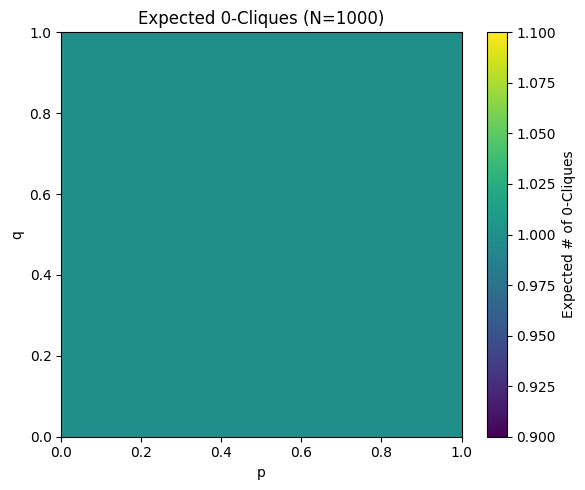

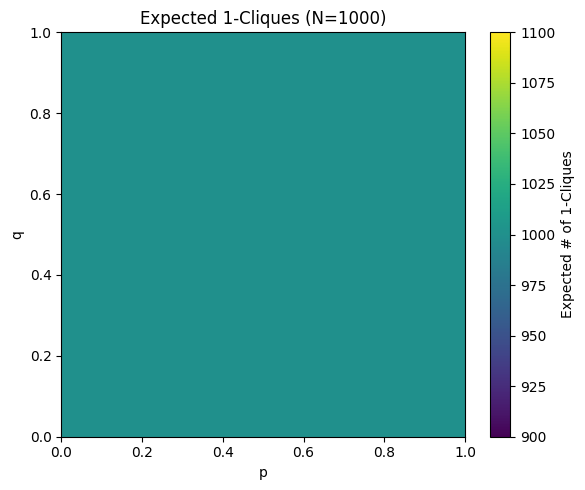

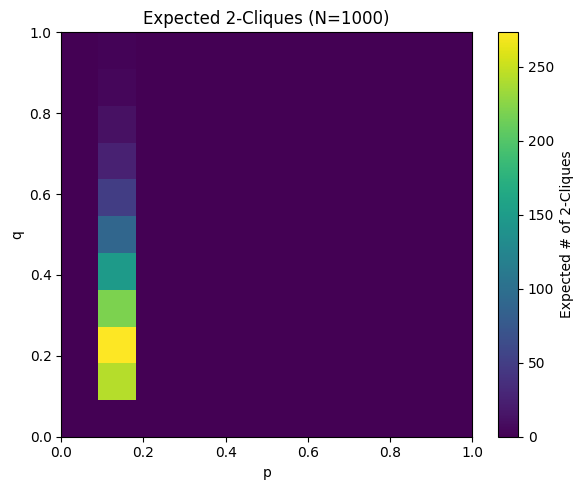

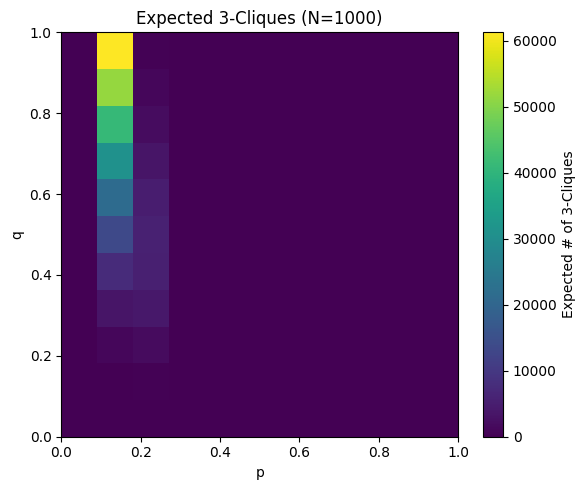

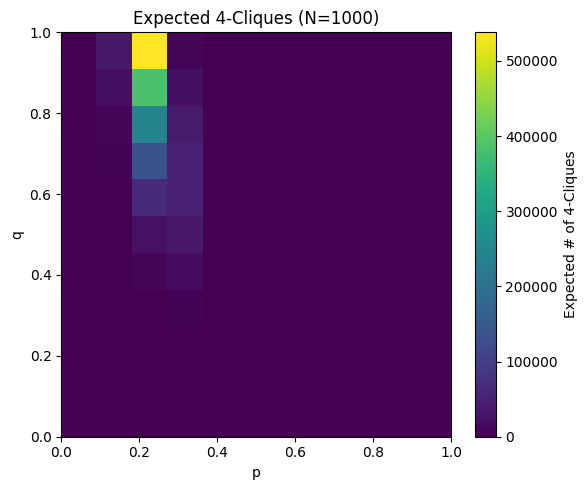

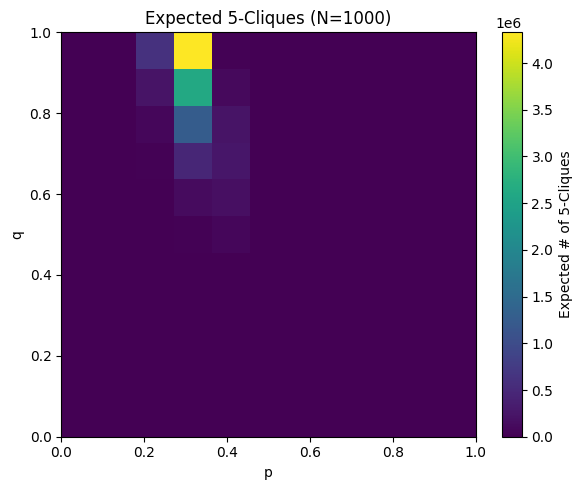

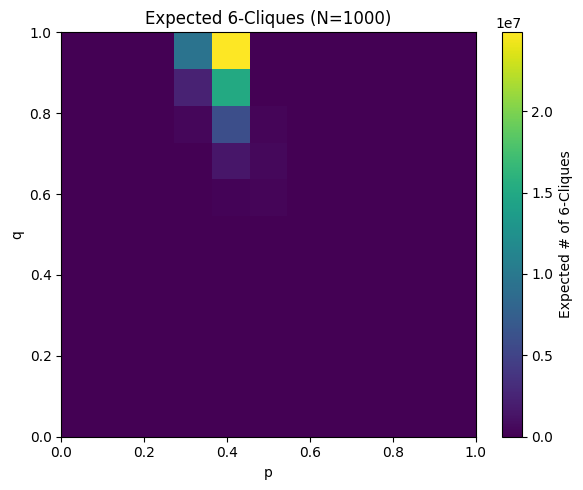

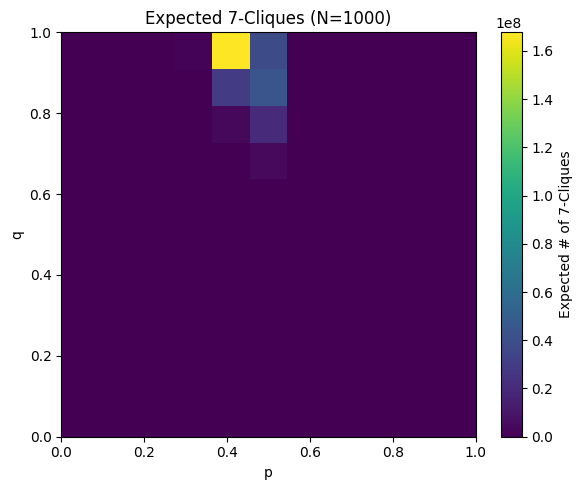

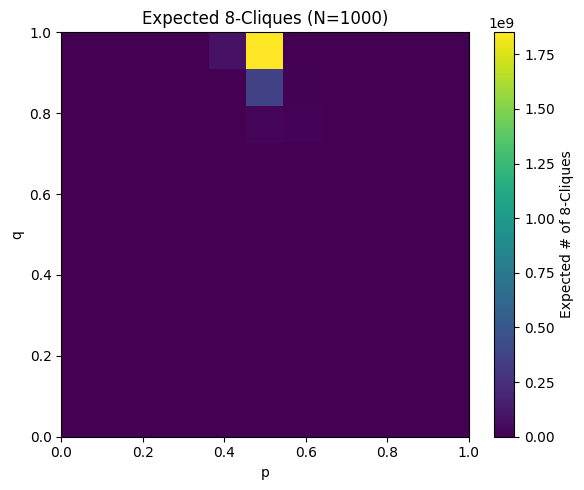

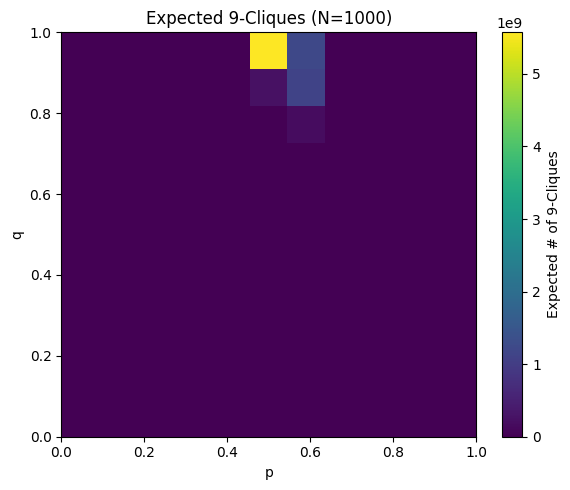

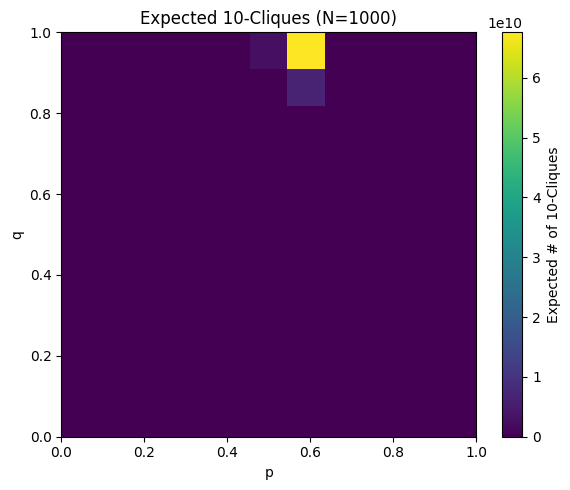

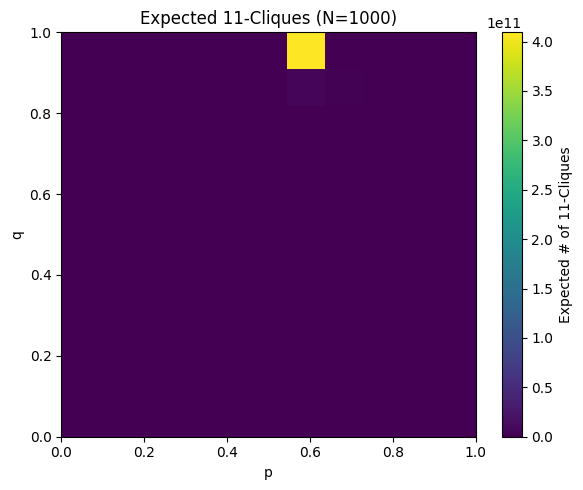

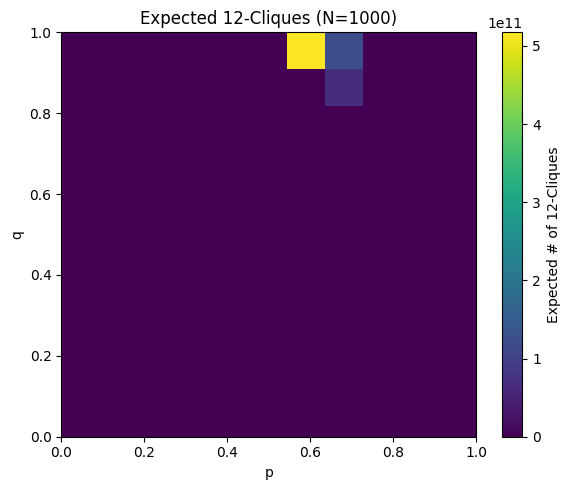

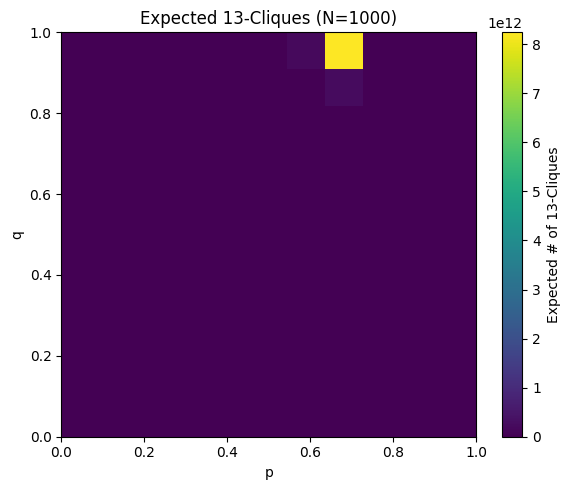

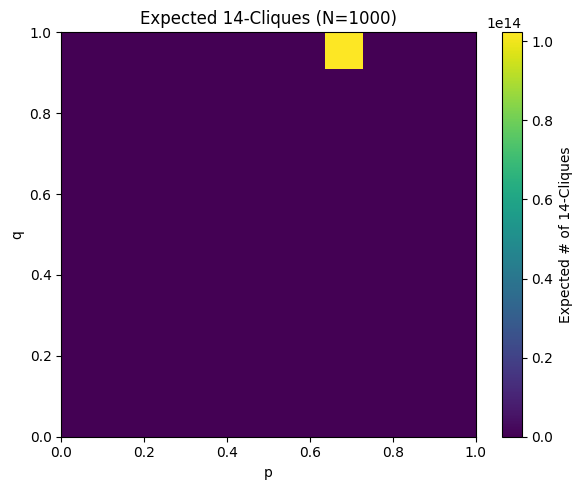

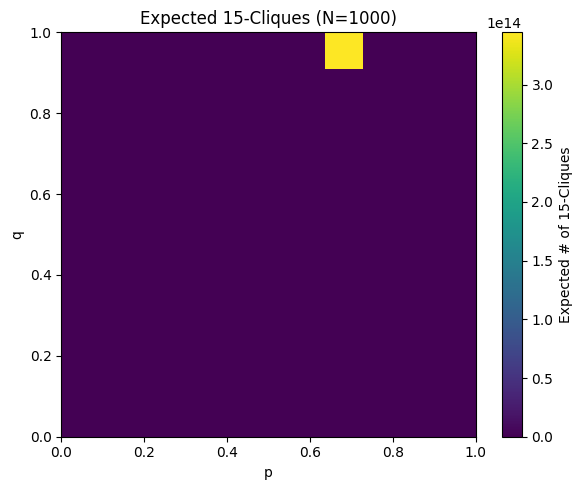

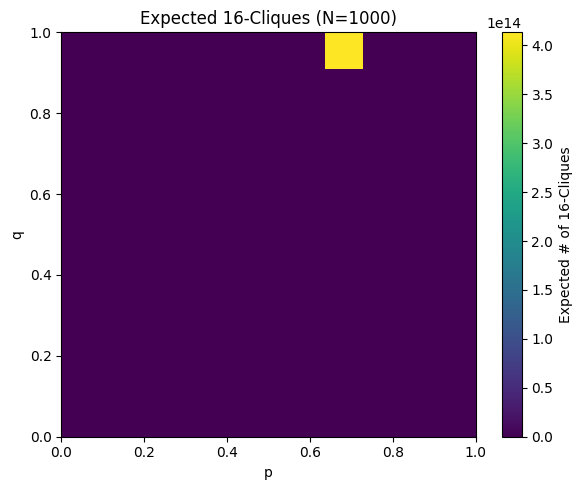

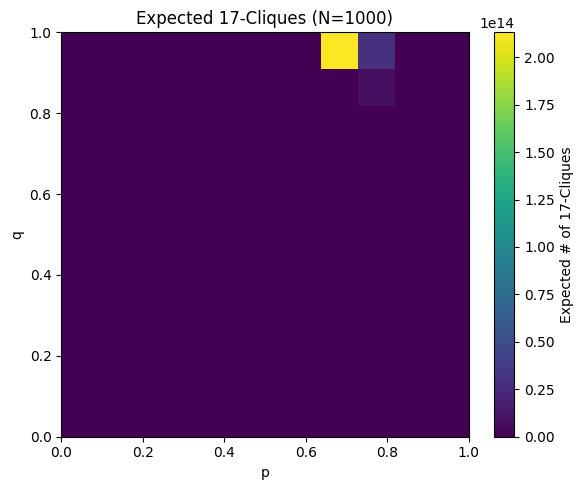

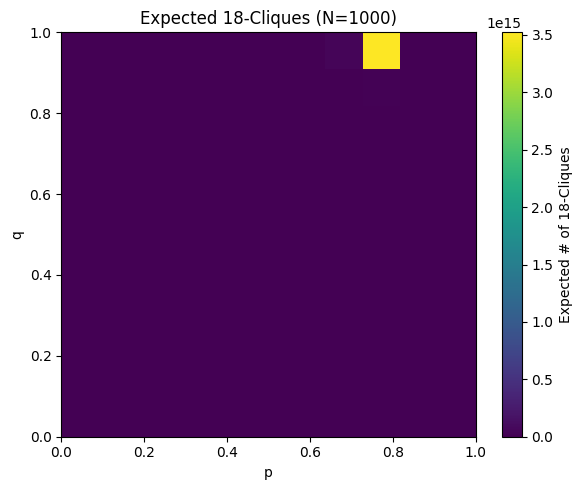

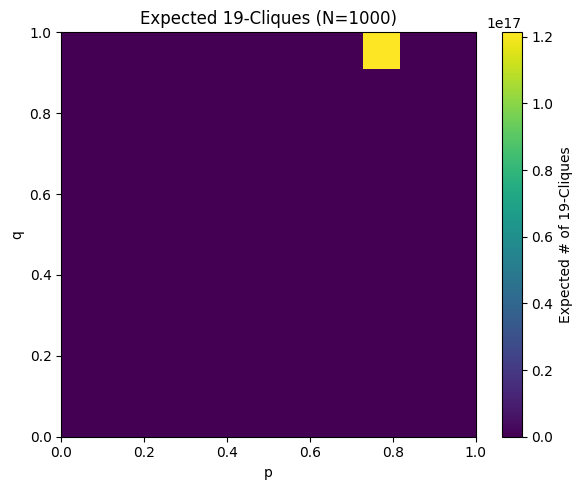

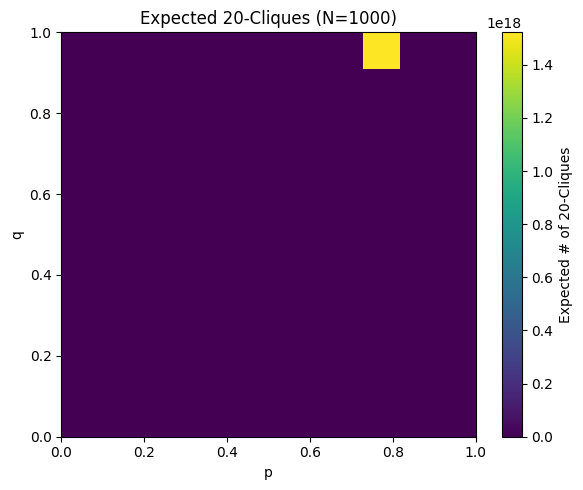

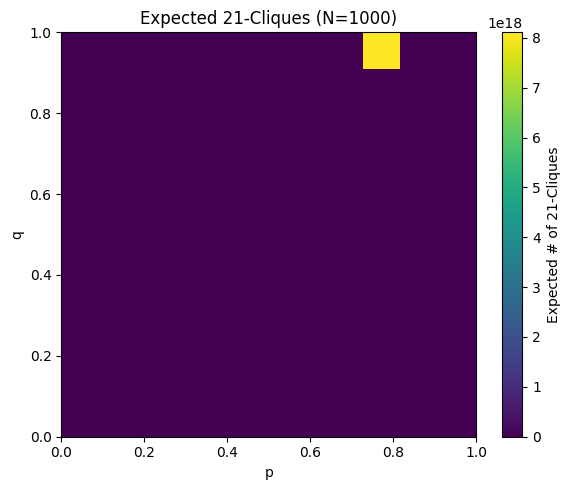

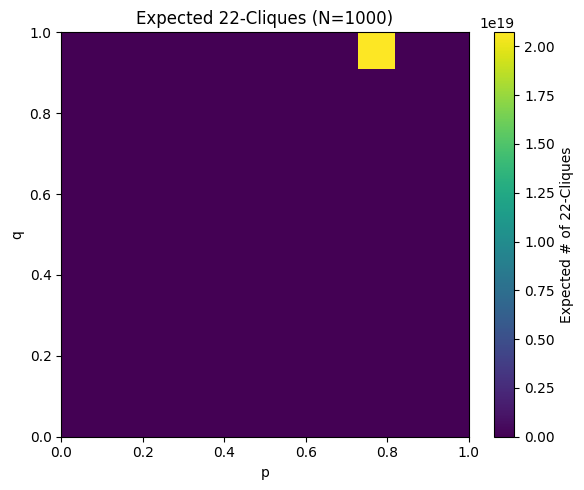

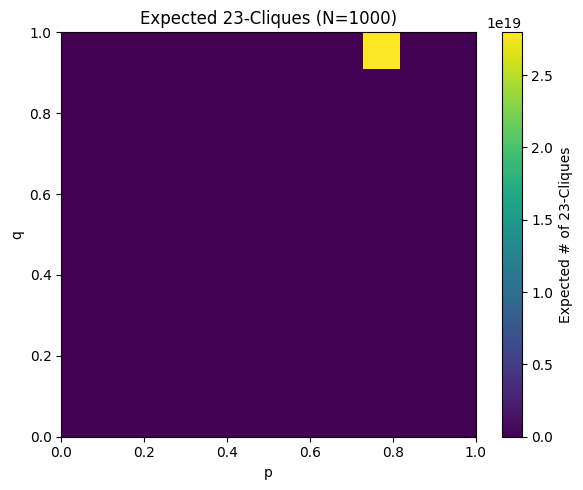

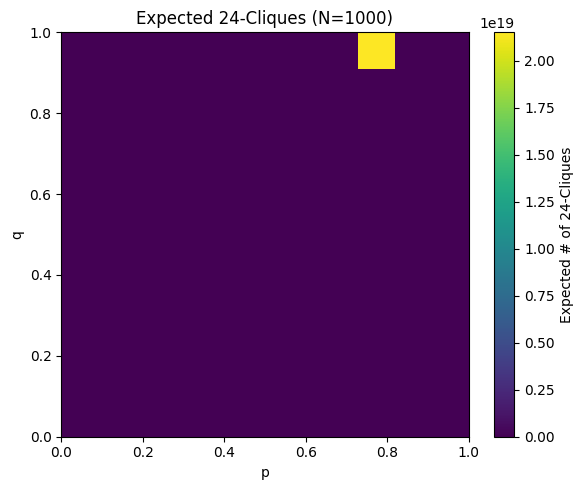

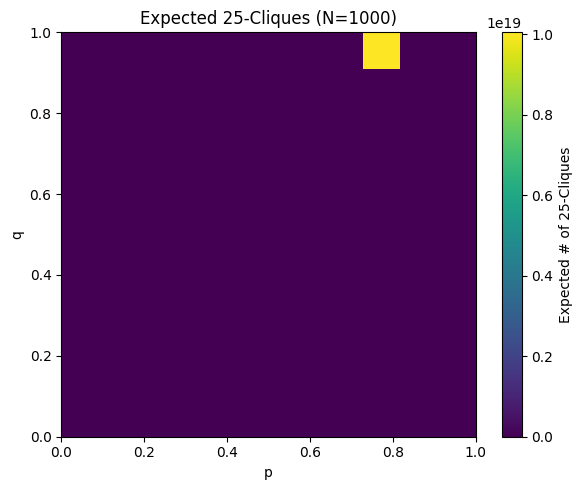

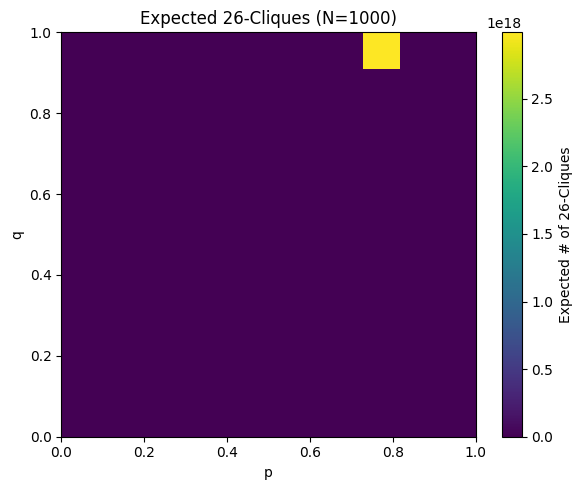

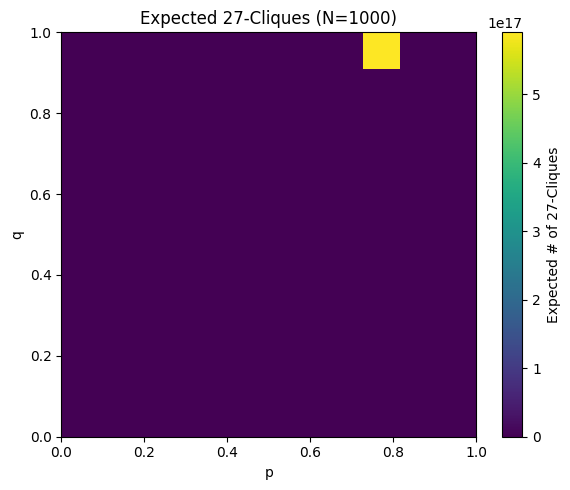

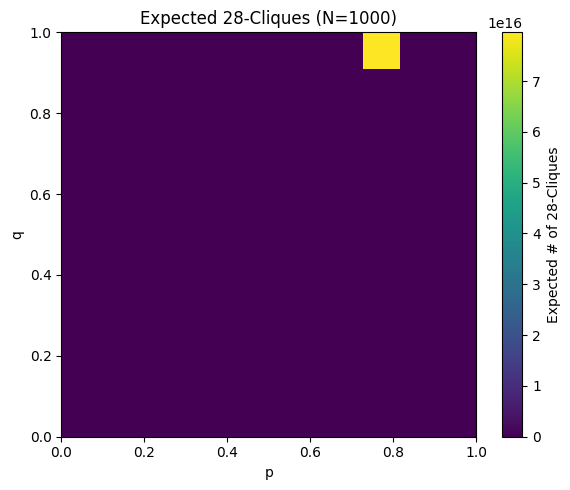

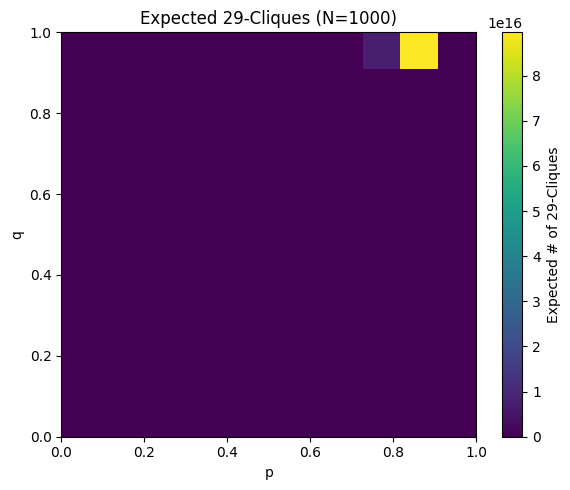

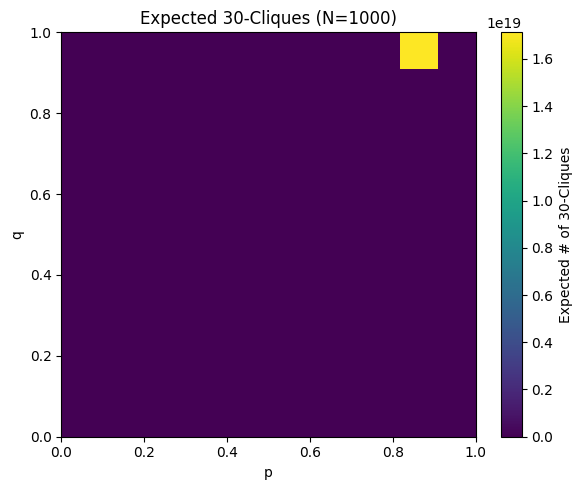

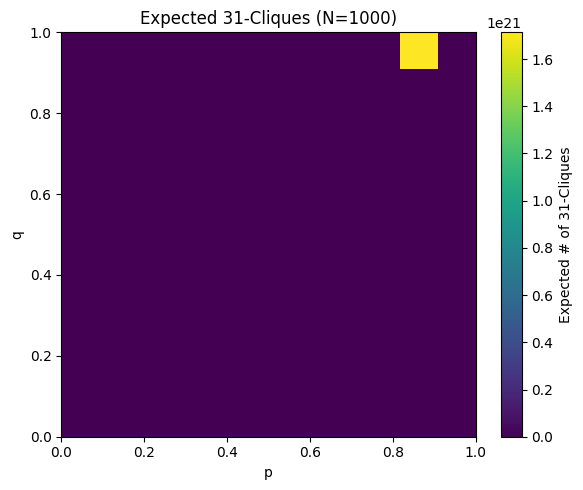

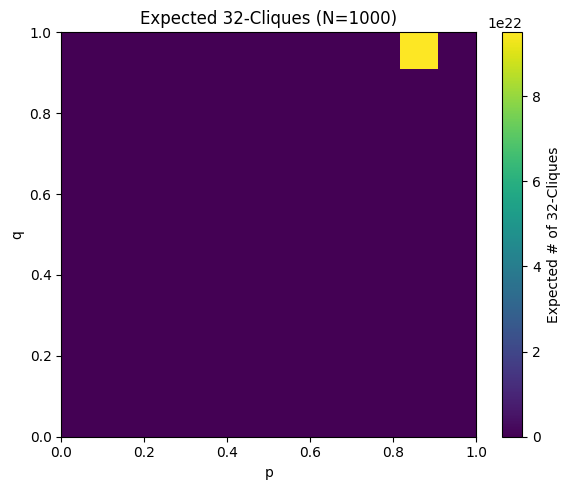

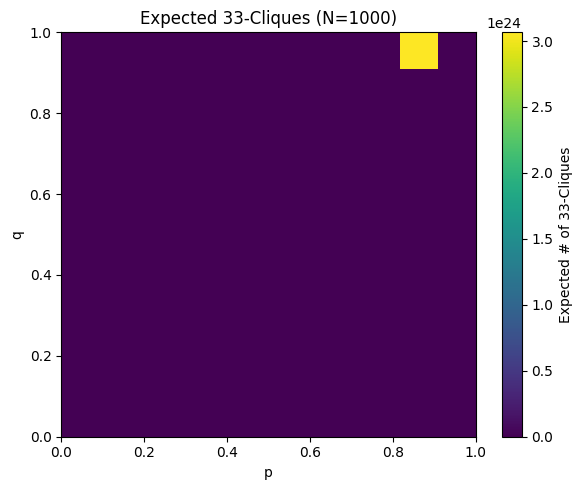

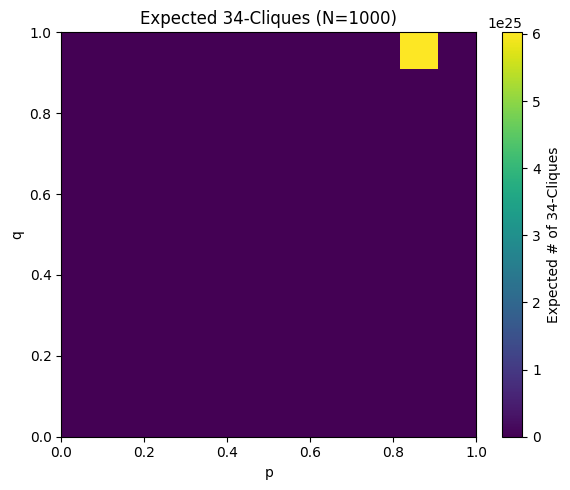

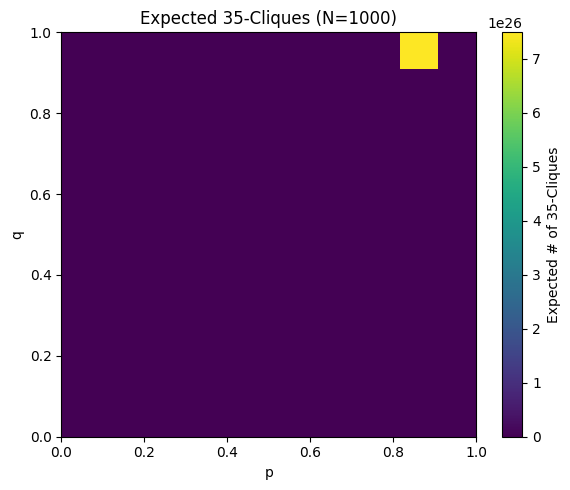

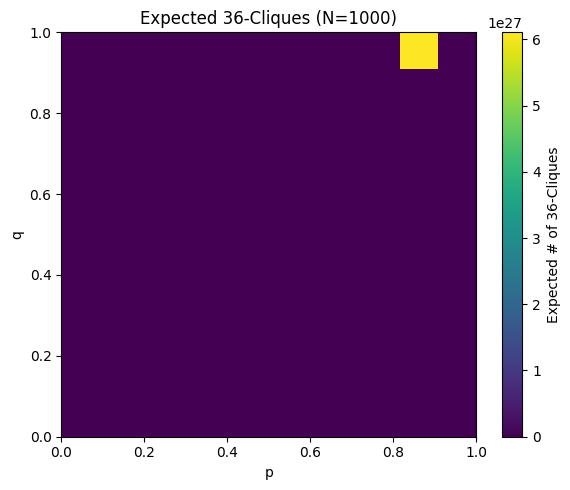

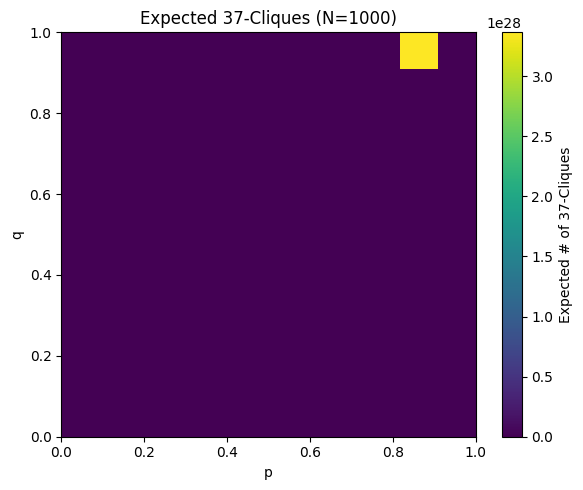

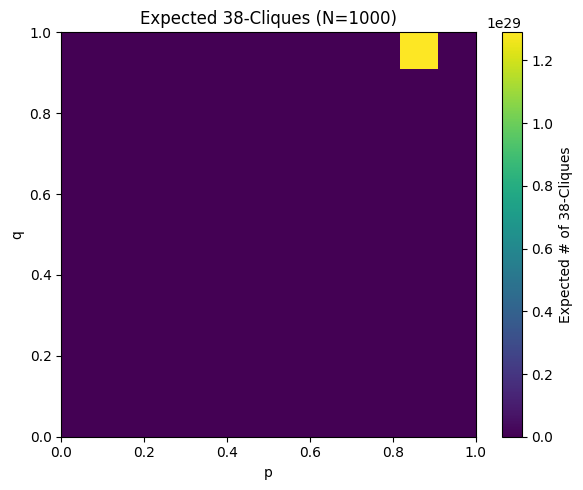

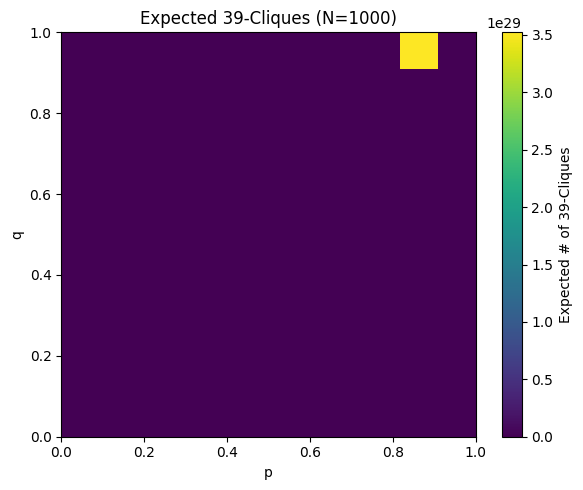

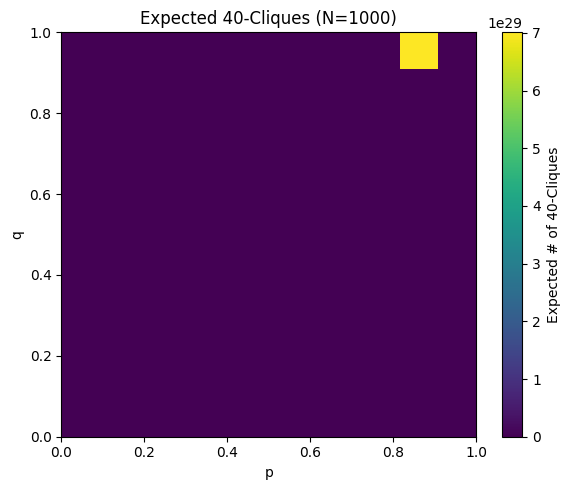

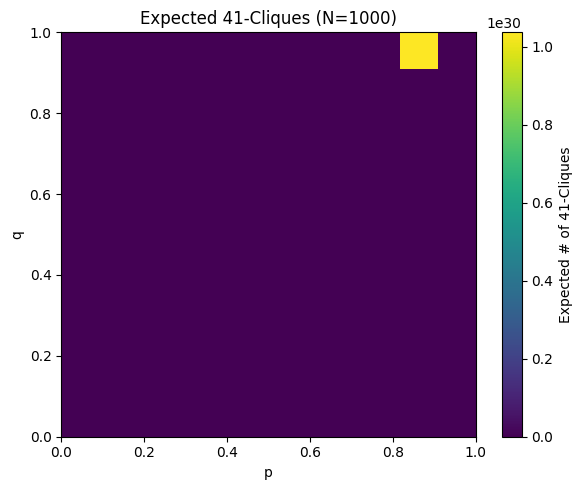

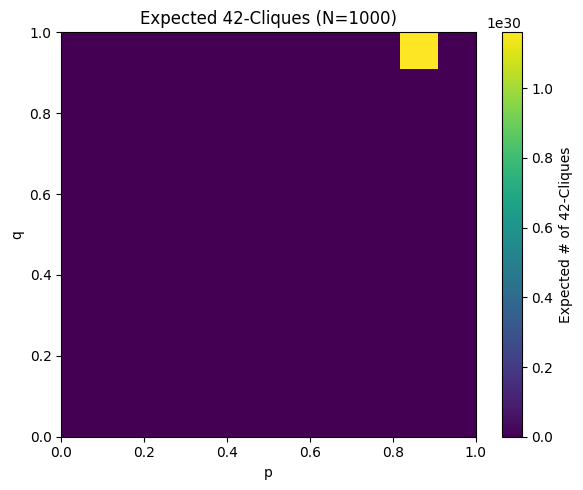

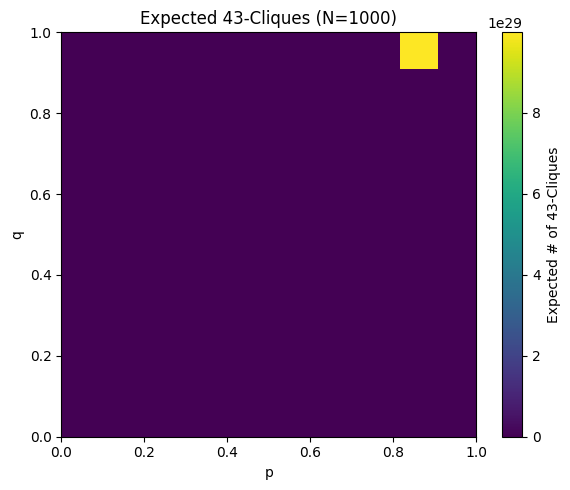

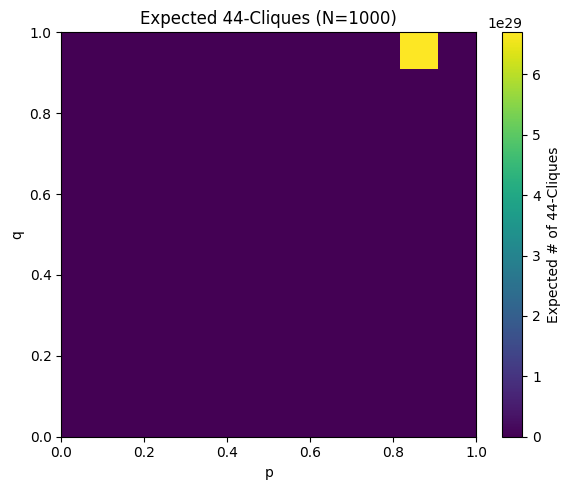

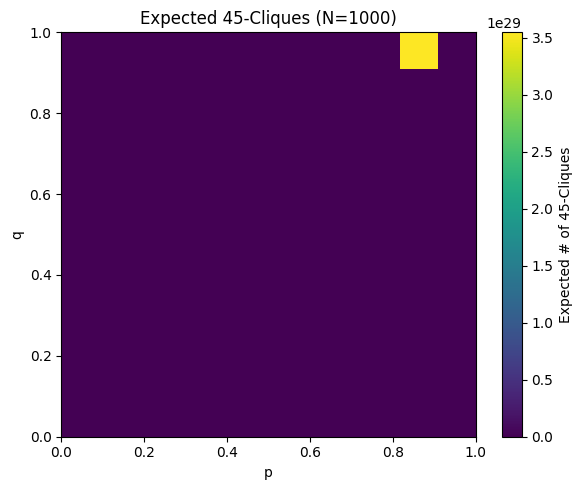

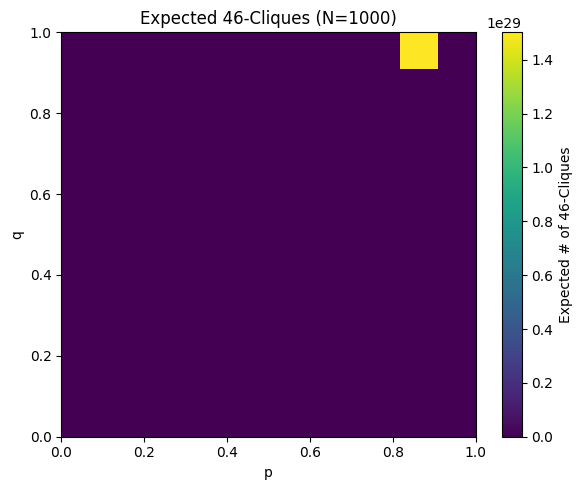

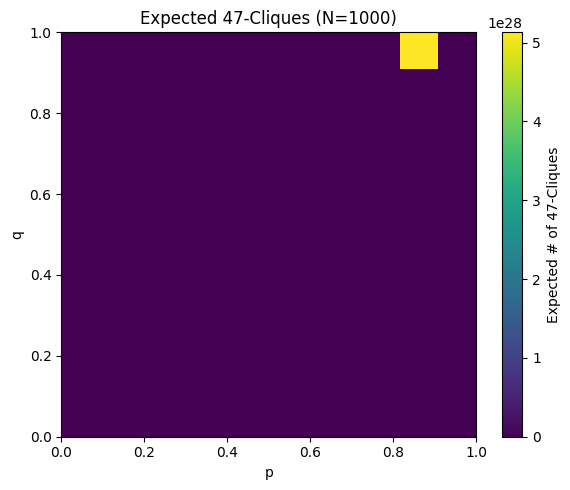

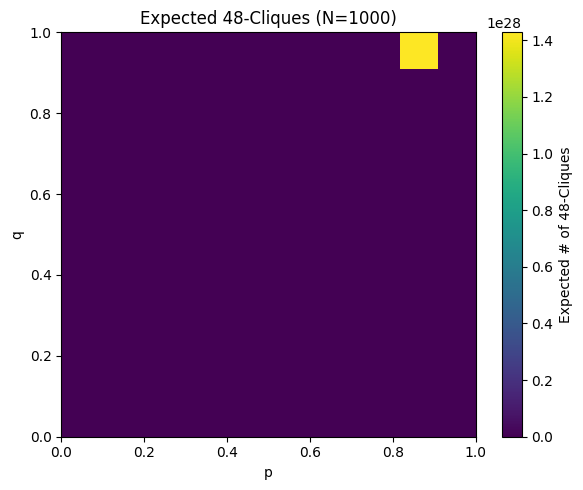

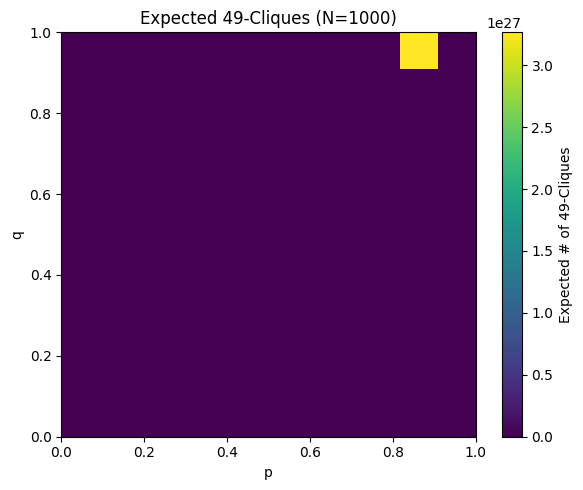

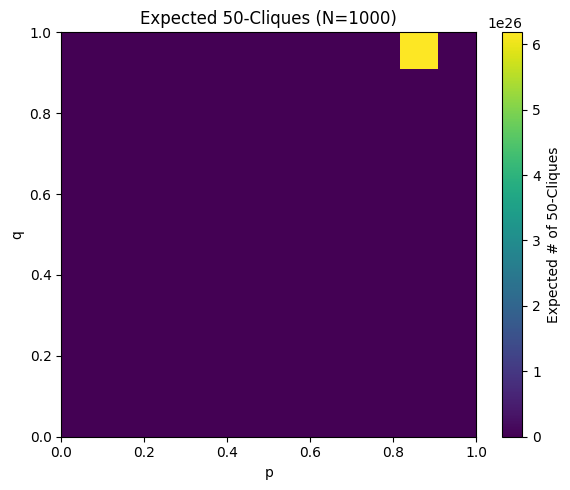

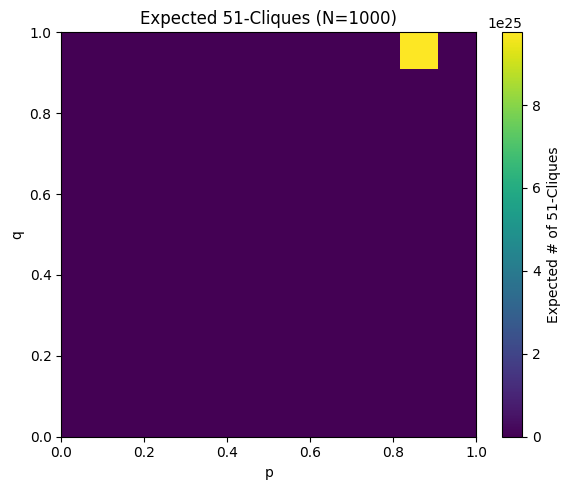

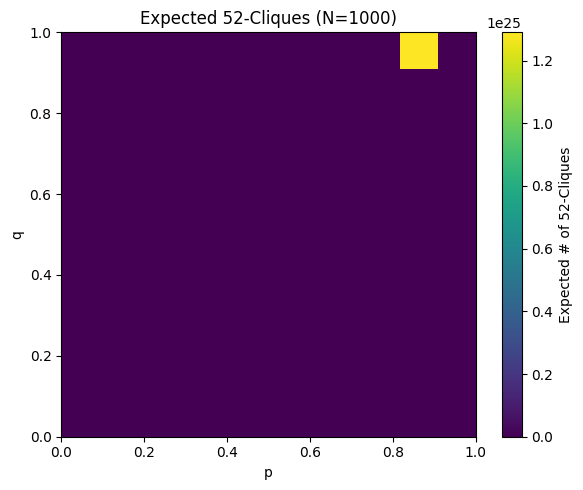

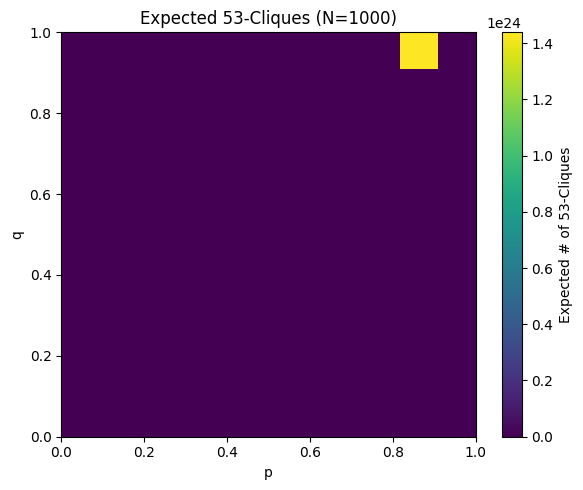

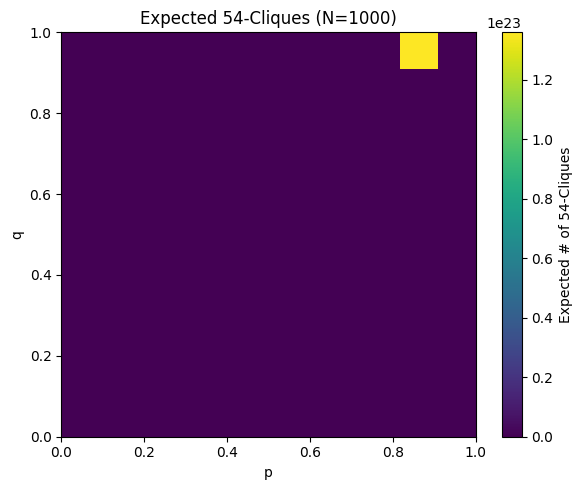

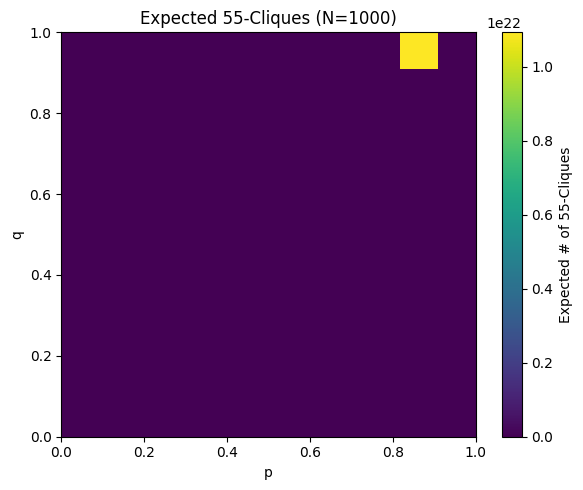

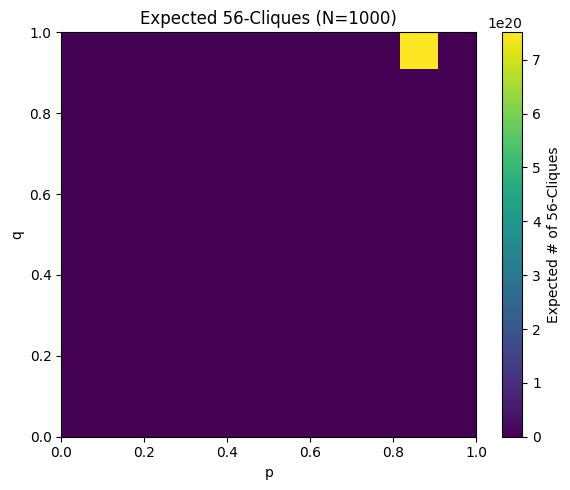

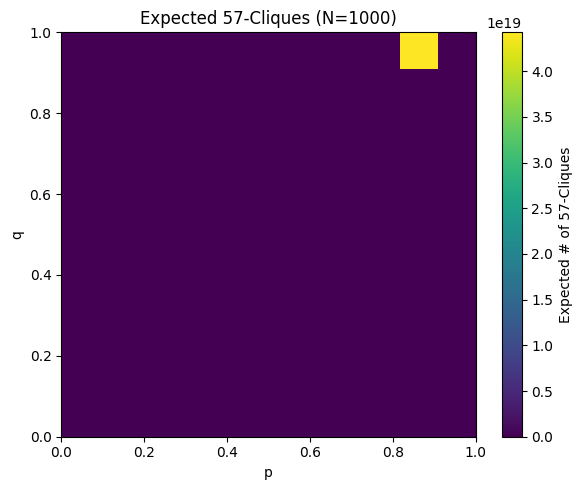

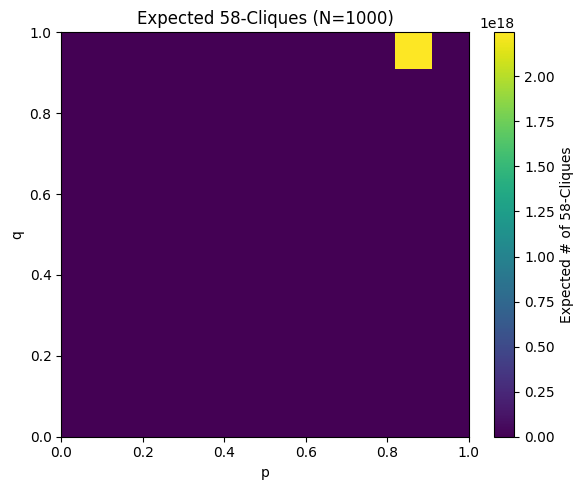

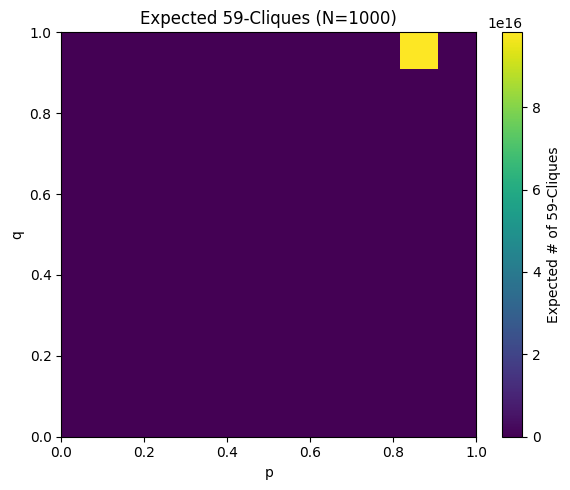

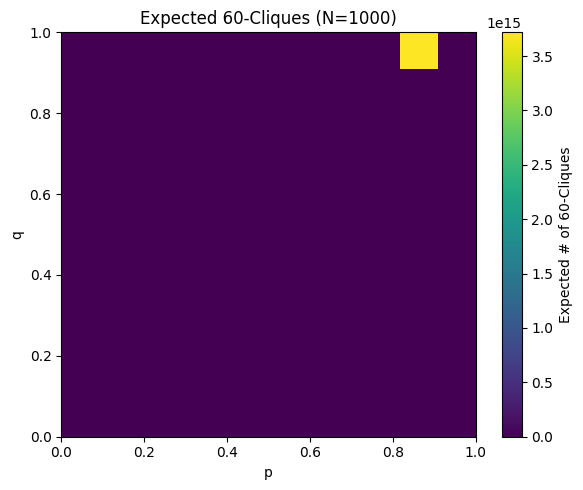

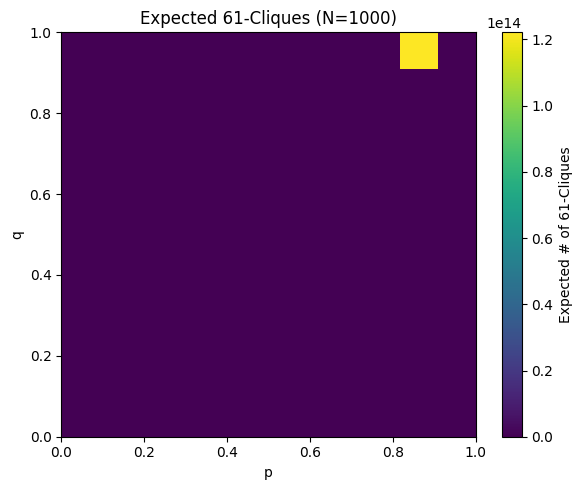

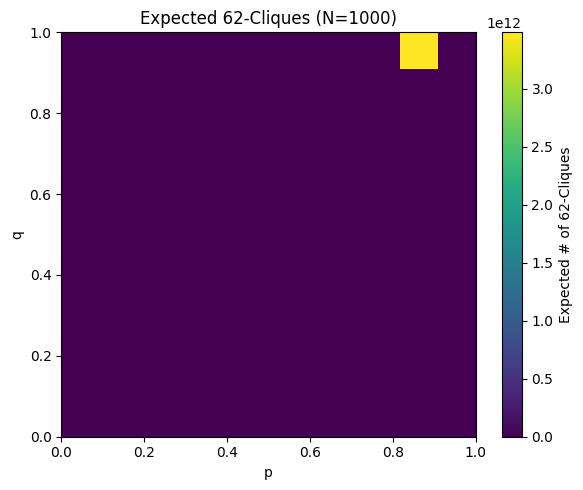

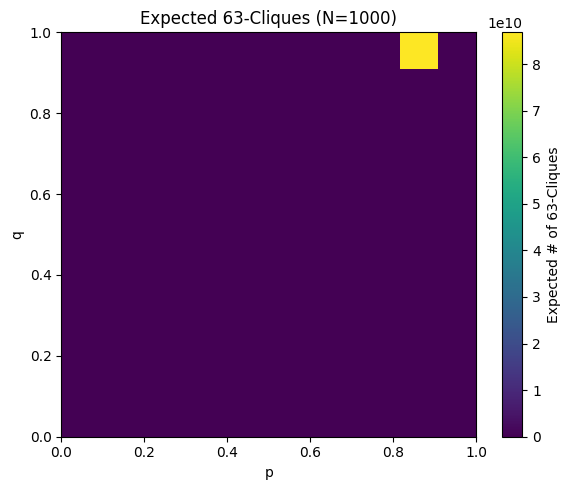

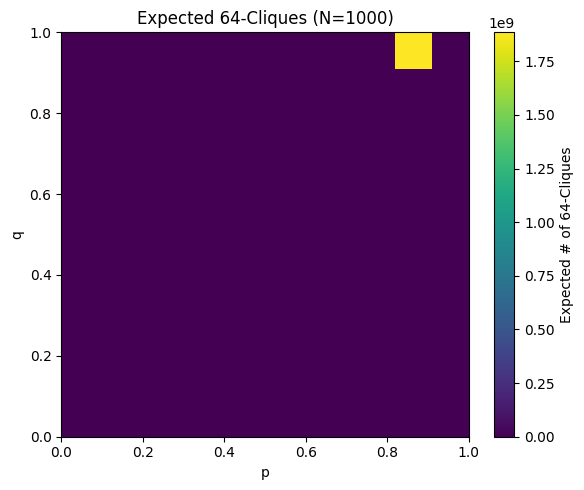

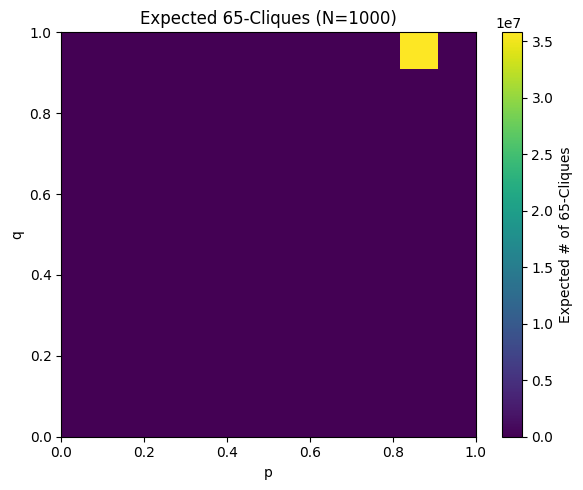

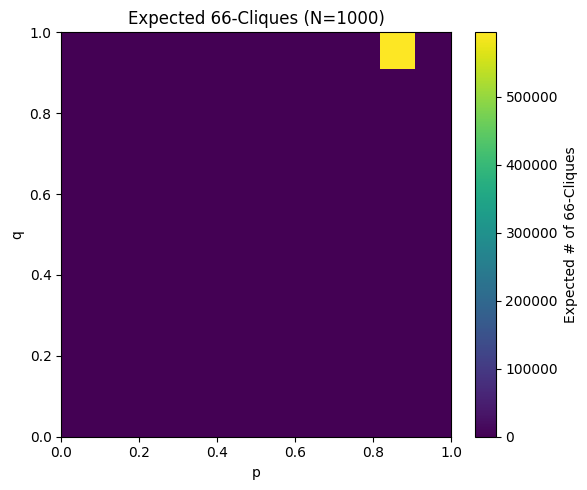

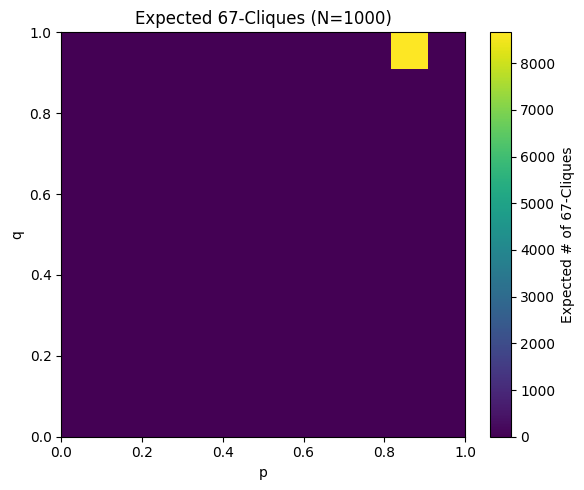

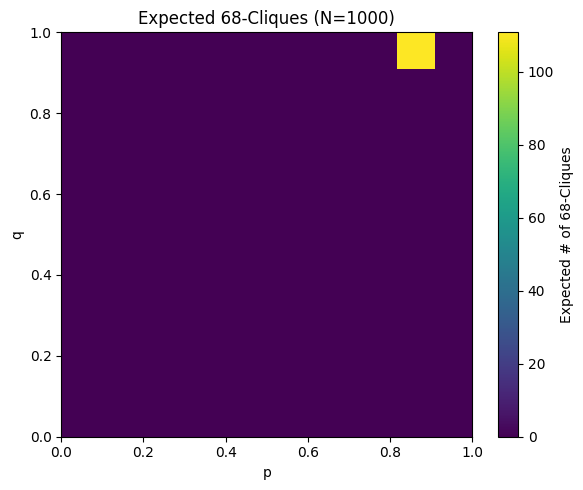

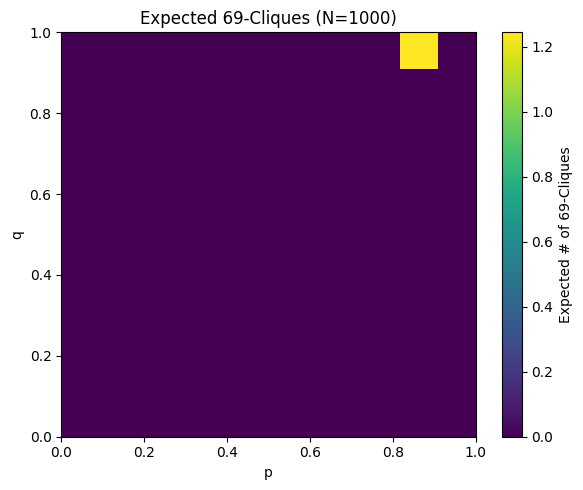

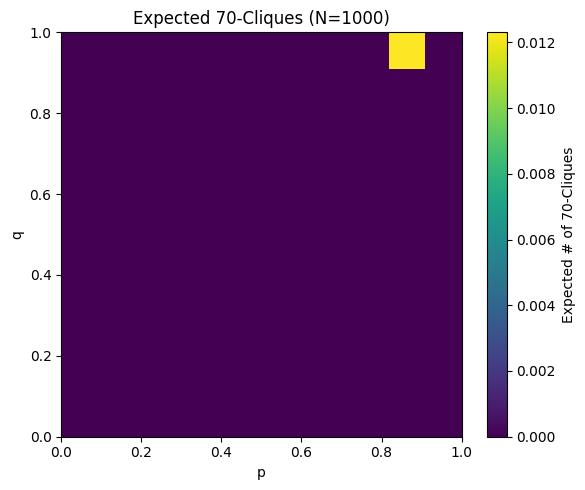

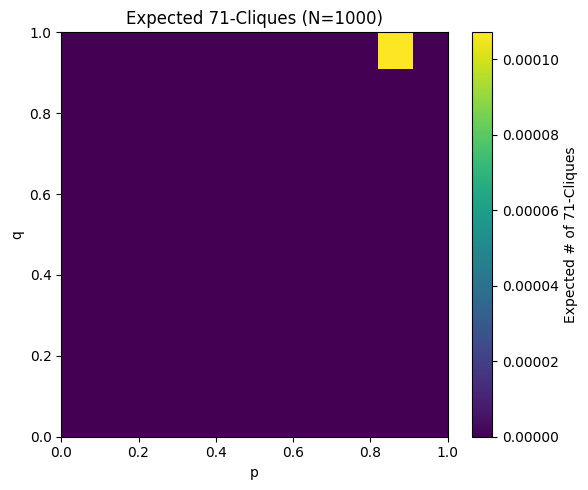

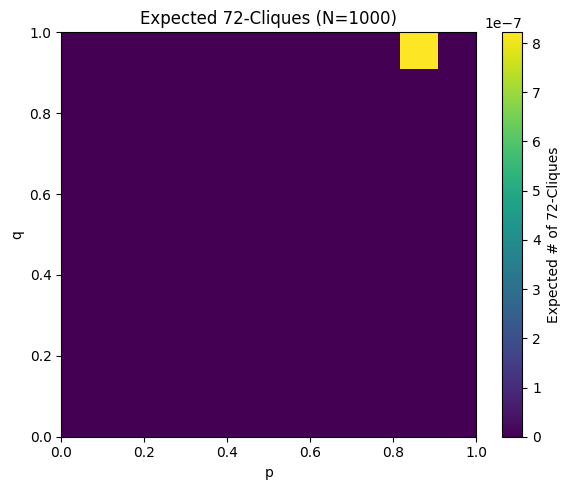

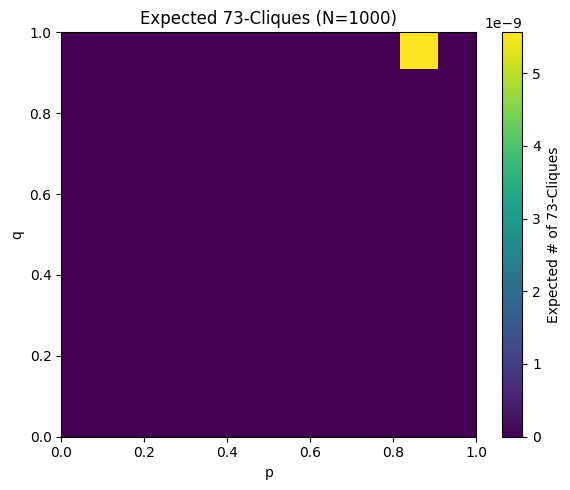

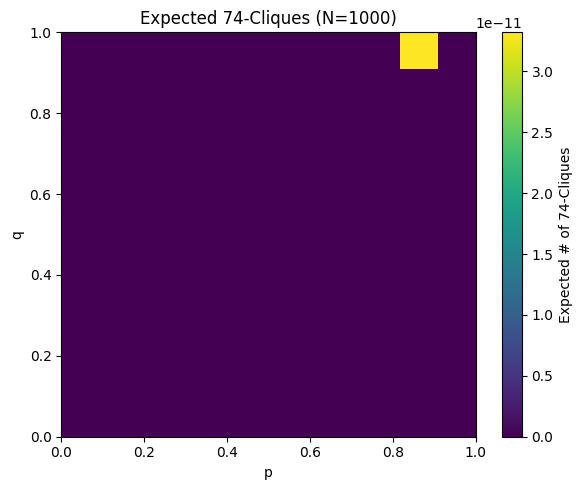

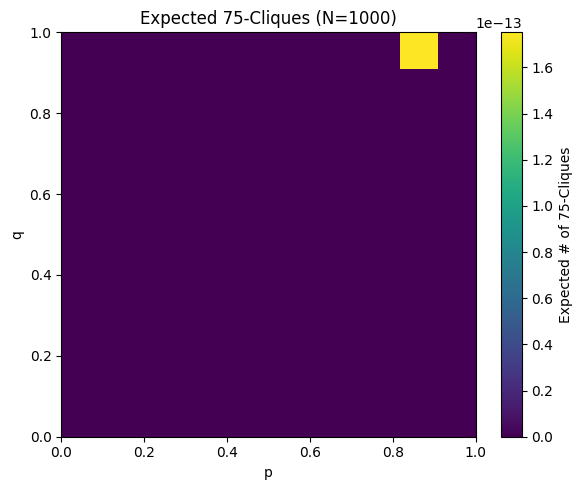

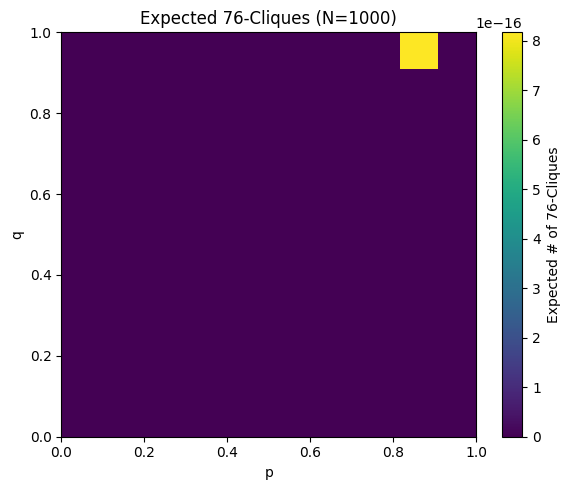

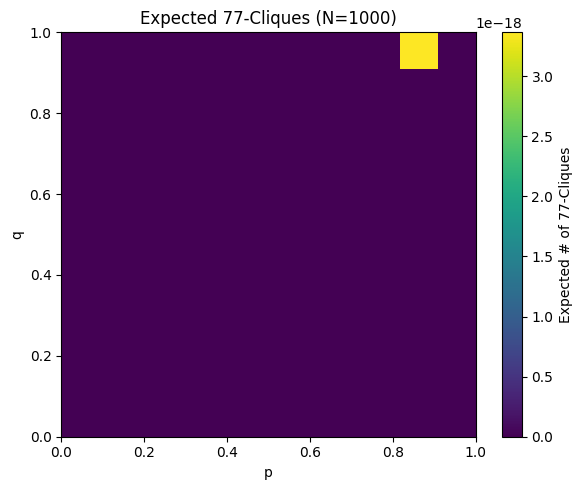

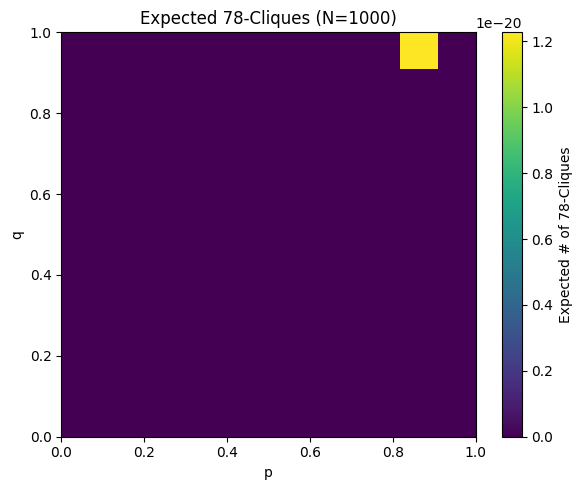

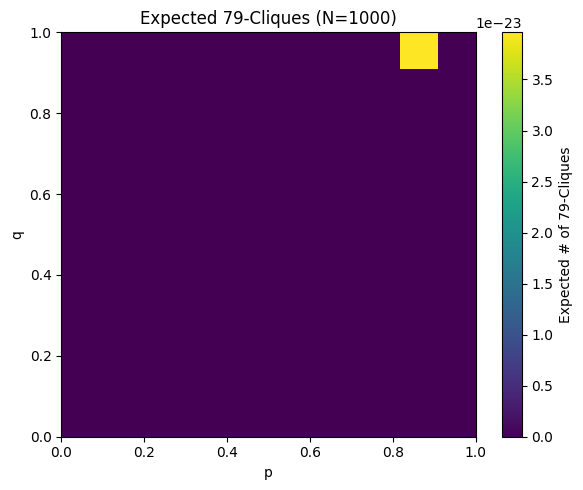

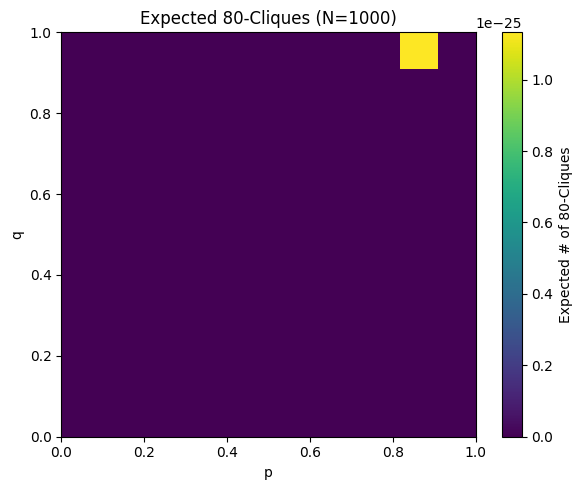

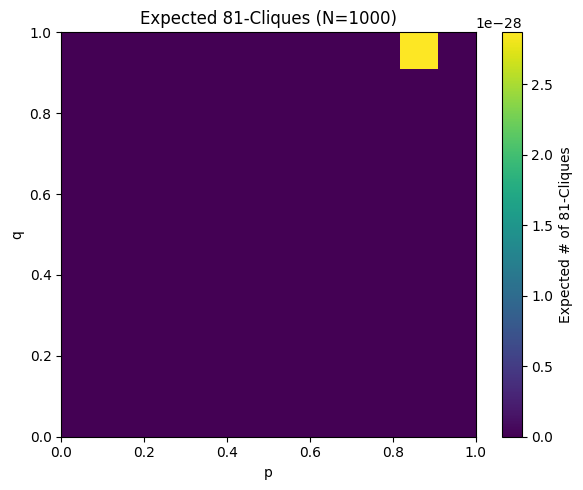

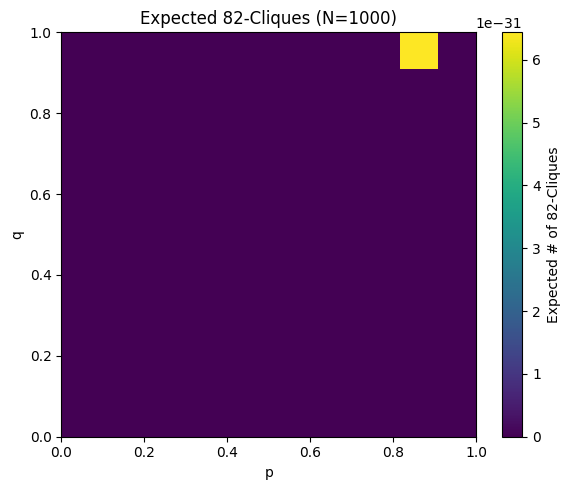

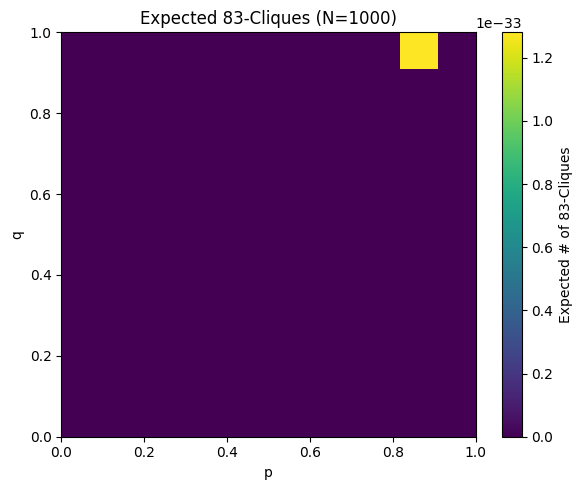

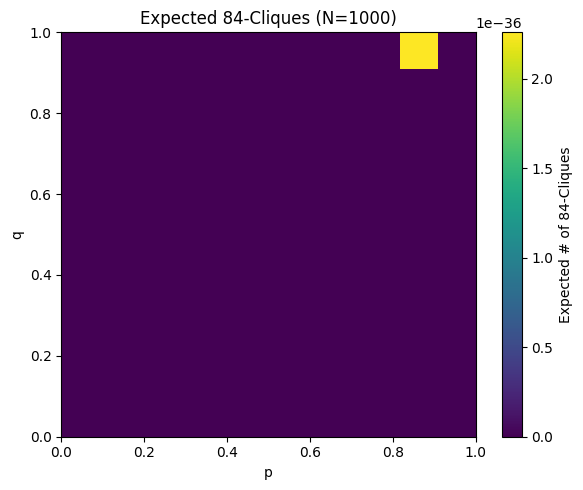

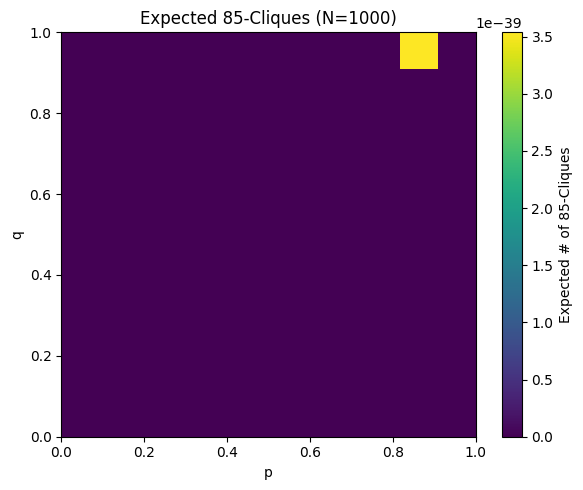

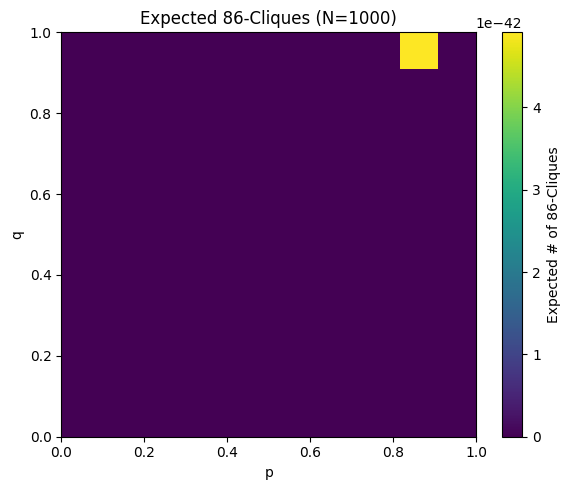

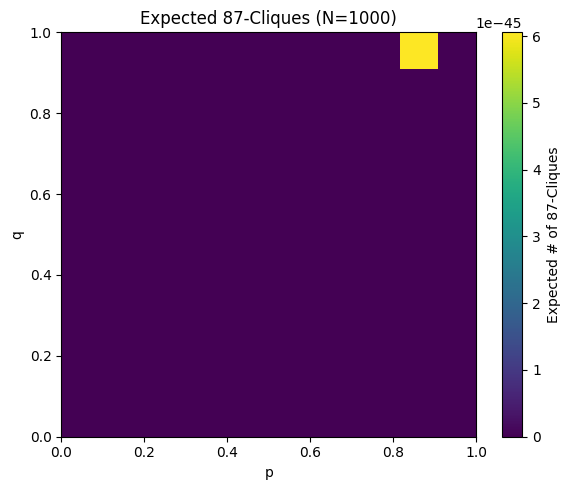

KeyboardInterrupt: 

In [12]:
# Set the number of nodes
N = 1000  # You can change N

# Define p and q values (0 to 1 in steps of 0.1)
p_values = np.arange(0, 1.01, 0.1)
q_values = np.arange(0, 1.01, 0.1)

# Number of steps in p and q
num_steps = len(p_values)

# Create a 3D array to store expected k-clique values: shape (N+1, len(p_values), len(q_values))
expected_k_cliques = np.zeros((N+1, num_steps, num_steps))

# Loop over all values of p, q, and k
for pi, p in enumerate(p_values):
    for qi, q in enumerate(q_values):
        for k in range(N + 1):
            if k < 2:
                expected = sc.comb(N, k)  # trivial case: cliques of size 0 or 1
            else:
                term1 = sc.comb(N, k)
                term2 = (p * q) ** sc.comb(k, 2)
                inner = (p * q + p * (1 - q) / 2) ** k
                term3 = (1 - inner) ** (N - k)
                expected = term1 * term2 * term3
            expected_k_cliques[k, qi, pi] = expected


# Plot heatmaps for each k
for k in range(N + 1):
    plt.figure(figsize=(6, 5))
    plt.imshow(expected_k_cliques[k], origin='lower', extent=(0, 1, 0, 1), aspect='auto', cmap='viridis')
    plt.colorbar(label='Expected # of {}-Cliques'.format(k))
    plt.title(f'Expected {k}-Cliques (N={N})')
    plt.xlabel('p')
    plt.ylabel('q')
    plt.tight_layout()
    plt.show()


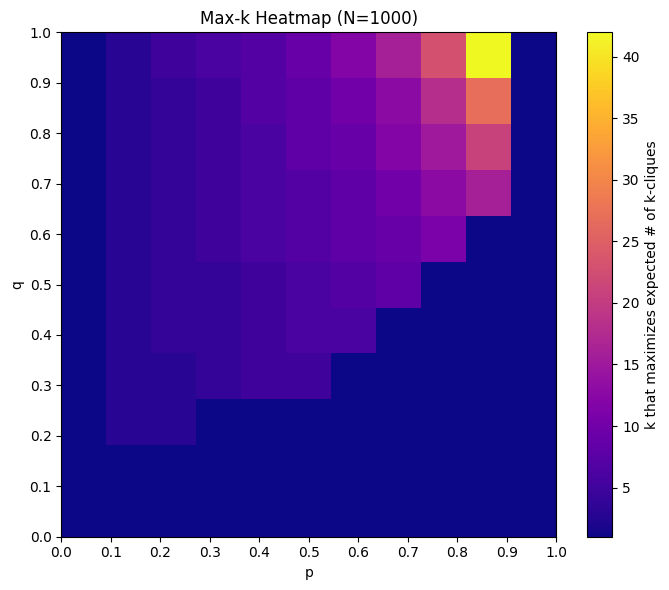

In [21]:
# Parameters
N = 1000
p_values = np.arange(0, 1.01, 0.1)
q_values = np.arange(0, 1.01, 0.1)
num_steps = len(p_values)

# Store expected k-cliques: shape (N+1, len(q), len(p))
expected_k_cliques = np.zeros((N + 1, num_steps, num_steps))

# Fill expected_k_cliques
for pi, p in enumerate(p_values):
    for qi, q in enumerate(q_values):
        for k in range(N + 1):
            if k < 2:
                expected = sc.comb(N, k)
            else:
                term1 = sc.comb(N, k)
                term2 = (p * q) ** sc.comb(k, 2)
                inner = (p * q + p * (1 - q) / 2) ** k
                term3 = (1 - inner) ** (N - k)
                expected = term1 * term2 * term3
            expected_k_cliques[k, qi, pi] = expected  # q as row, p as column

# Find k that maximizes expected number of k-cliques at each (q, p)
max_k_map = np.argmax(expected_k_cliques, axis=0)  # shape: (len(q), len(p))

# Plot heatmap of max k
plt.figure(figsize=(7, 6))
plt.imshow(max_k_map, origin='lower', extent=(0, 1, 0, 1), cmap='plasma', aspect='auto')
plt.colorbar(label='k that maximizes expected # of k-cliques')
plt.xlabel('p')
plt.ylabel('q')
plt.title(f'Max-k Heatmap (N={N})')
plt.xticks(np.round(p_values, 2))
plt.yticks(np.round(q_values, 2))
plt.grid(False)
plt.tight_layout()
plt.show()


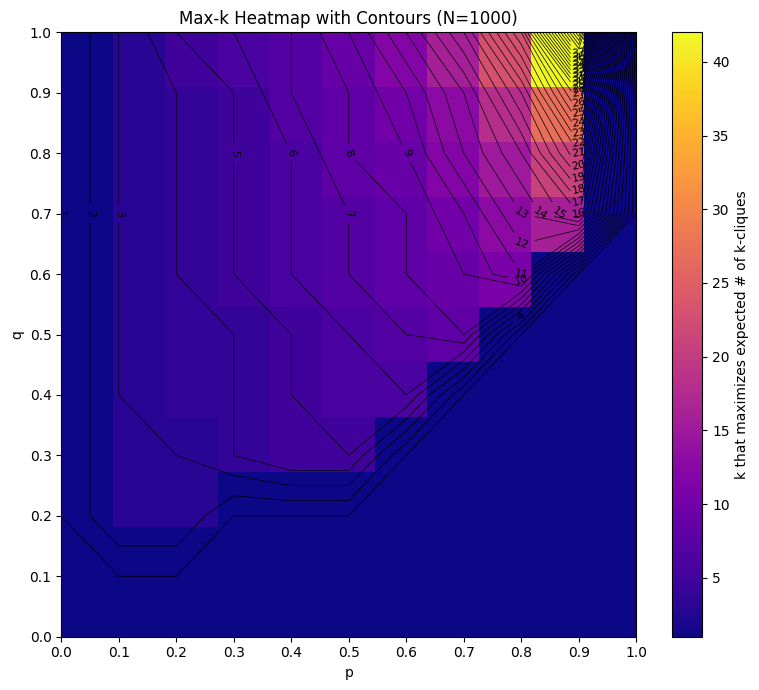

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

# Parameters
N = 1000
p_values = np.arange(0, 1.01, 0.1)
q_values = np.arange(0, 1.01, 0.1)
num_steps = len(p_values)

# Store expected k-cliques: shape (N+1, len(q), len(p))
expected_k_cliques = np.zeros((N + 1, num_steps, num_steps))

# Fill expected_k_cliques
for pi, p in enumerate(p_values):
    for qi, q in enumerate(q_values):
        for k in range(N + 1):
            if k < 2:
                expected = comb(N, k)
            else:
                term1 = comb(N, k)
                term2 = (p * q) ** comb(k, 2)
                inner = (p * q + p * (1 - q) / 2) ** k
                term3 = (1 - inner) ** (N - k)
                expected = term1 * term2 * term3
            expected_k_cliques[k, qi, pi] = expected  # q as row, p as column

# Find k that maximizes expected number of k-cliques at each (q, p)
max_k_map = np.argmax(expected_k_cliques, axis=0)  # shape: (len(q), len(p))

# Plot heatmap of max k
plt.figure(figsize=(8, 7))
img = plt.imshow(max_k_map, origin='lower', extent=(0, 1, 0, 1), cmap='plasma', aspect='auto')
plt.colorbar(img, label='k that maximizes expected # of k-cliques')

# Add contour lines
P, Q = np.meshgrid(p_values, q_values)
contour = plt.contour(P, Q, max_k_map, levels=np.arange(N+1), colors='black', linewidths=0.5)
plt.clabel(contour, inline=True, fontsize=8, fmt='%d')

# Labels and title
plt.xlabel('p')
plt.ylabel('q')
plt.title(f'Max-k Heatmap with Contours (N={N})')
plt.xticks(np.round(p_values, 2))
plt.yticks(np.round(q_values, 2))
plt.grid(False)
plt.tight_layout()
plt.show()


0.34967580379024177 0.7408442133333893 0.13545530742247325


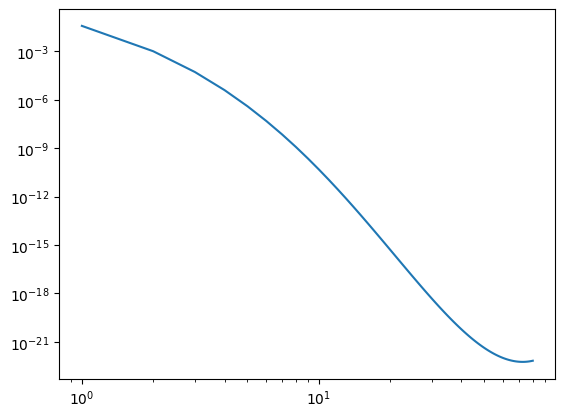

In [2]:
# limit

def f(a,p,q,N):
    u =np.sqrt(2*np.pi*N)*(N/e)**N
    v = np.sqrt(2*np.pi * a * N) * ((a*N)/e)**(a*N) * np.sqrt(2*np.pi*(N*(1-a))) * ((N*(1-a))/e)**(N*(1-a))
    w = p*q 
    bin_exp = ((a*N)**2-a*N)/2
    x = (1-(p*((1-q)/2)+p*q)**(a*N))**(N*(1-a))
    return((u/v)*(w**bin_exp)*x)

x_coords=[]
entries=[]
entries_2=[]
entries_3=[]

r1 = np.random.uniform(0,1)
r2 = np.random.uniform(0,1)
r3 = np.random.uniform(0,1)

print(r1,r2,r3)

for i in range(80):
    # entries.append(f(1/2,1/2,1/2,i+1))
    # entries_2.append(f(0.3,0.6,0,i+1))
    entries_3.append(f(0.01, r2, r3,i+1))
    x_coords.append(i+1)

# plt.loglog(x_coords, entries)
# plt.loglog(x_coords, entries_2)
plt.loglog(x_coords, entries_3)